In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Import TensorFlow
import tensorflow as tf

# Set seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(2)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

In [2]:
data = pd.read_csv('D:Car_sales(1).csv')

In [3]:
data.head(5)

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Sales_Date,Power_perf_factor
0,Acura,Integra,16.919,16.360,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2018,58.280150
1,Acura,TL,39.384,19.875,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2019,91.370778
2,Acura,CL,14.114,18.225,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2018,NaN
3,Acura,RL,8.588,29.725,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2019,91.389779
4,Audi,A4,20.397,22.255,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2019,62.777639


In [4]:
#Handle Missing value

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         157 non-null    object 
 1   Model                157 non-null    object 
 2   Sales_in_thousands   157 non-null    float64
 3   __year_resale_value  121 non-null    float64
 4   Price_in_thousands   155 non-null    float64
 5   Engine_size          156 non-null    float64
 6   Horsepower           156 non-null    float64
 7   Wheelbase            156 non-null    float64
 8   Width                156 non-null    float64
 9   Length               156 non-null    float64
 10  Curb_weight          155 non-null    float64
 11  Fuel_capacity        156 non-null    float64
 12  Fuel_efficiency      154 non-null    float64
 13  Sales_Date           157 non-null    object 
 14  Power_perf_factor    155 non-null    float64
dtypes: float64(12), object(3)
memory usage: 

In [5]:
data.isna().sum()

Manufacturer            0
Model                   0
Sales_in_thousands      0
__year_resale_value    36
Price_in_thousands      2
Engine_size             1
Horsepower              1
Wheelbase               1
Width                   1
Length                  1
Curb_weight             2
Fuel_capacity           1
Fuel_efficiency         3
Sales_Date              0
Power_perf_factor       2
dtype: int64

In [6]:
# Modify Value

data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])
data['Year'] = data['Sales_Date'].dt.year
data['Month'] = data['Sales_Date'].dt.month
data['Day'] = data['Sales_Date'].dt.day

In [7]:
data.head(5)

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Sales_Date,Power_perf_factor,Year,Month,Day
0,Acura,Integra,16.919,16.360,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2018-02-02,58.280150,2018,2,2
1,Acura,TL,39.384,19.875,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,2019-06-03,91.370778,2019,6,3
2,Acura,CL,14.114,18.225,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,2018-01-04,NaN,2018,1,4
3,Acura,RL,8.588,29.725,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2019-03-10,91.389779,2019,3,10
4,Audi,A4,20.397,22.255,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,2019-10-08,62.777639,2019,10,8


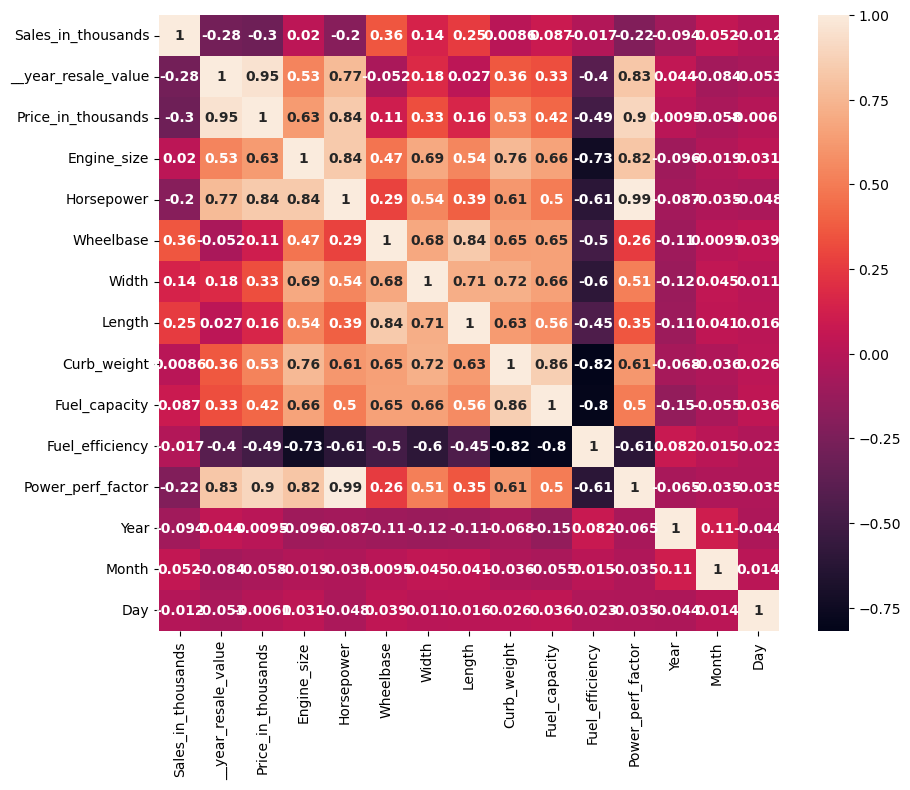

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(method='pearson'), annot=True, annot_kws={"weight": "bold"})
plt.show()

In [9]:
data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])

In [10]:
data.sort_values('Sales_Date', inplace=True)


In [11]:
def create_lag_features(data, lag):
    for i in range(1, lag+1):
        data[f'lag_{i}'] = data['Sales_in_thousands'].shift(i)
    return data

In [12]:
lag = 5


In [13]:
data = create_lag_features(data, lag)


In [14]:
data.dropna(inplace=True)


In [15]:
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [16]:
X_train, y_train = train_data.drop(['Sales_Date', 'Sales_in_thousands'], axis=1), train_data['Sales_in_thousands']
X_test, y_test = test_data.drop(['Sales_Date', 'Sales_in_thousands'], axis=1), test_data['Sales_in_thousands']

In [17]:
import xgboost as xgb
xgb.config_context(enable_categorical=True)

In [18]:
data['Manufacturer'] = data['Manufacturer'].astype('category')
data['Model'] = data['Model'].astype('category')


In [19]:
lag = 5

In [20]:
data = create_lag_features(data, lag)


In [21]:
data.dropna(inplace=True)


In [22]:
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [23]:
X_train, y_train = train_data.drop(['Sales_Date', 'Sales_in_thousands'], axis=1), train_data['Sales_in_thousands']
X_test, y_test = test_data.drop(['Sales_Date', 'Sales_in_thousands'], axis=1), test_data['Sales_in_thousands']

In [24]:
data['Manufacturer'] = data['Manufacturer'].astype('category')
data['Model'] = data['Model'].astype('category')


In [25]:
import xgboost as xgb
xgb.config_context(enable_categorical=True)

In [26]:
data['Manufacturer'] = data['Manufacturer'].astype('category')
data['Model'] = data['Model'].astype('category')


In [27]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [28]:
params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
    }

In [29]:
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [30]:
y_pred = model.predict(dtest)

In [31]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 62.46030942409299


In [32]:
data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])
data.set_index('Sales_Date', inplace=True)
y_pred_series = pd.Series(y_pred, index=X_test.index)

In [33]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

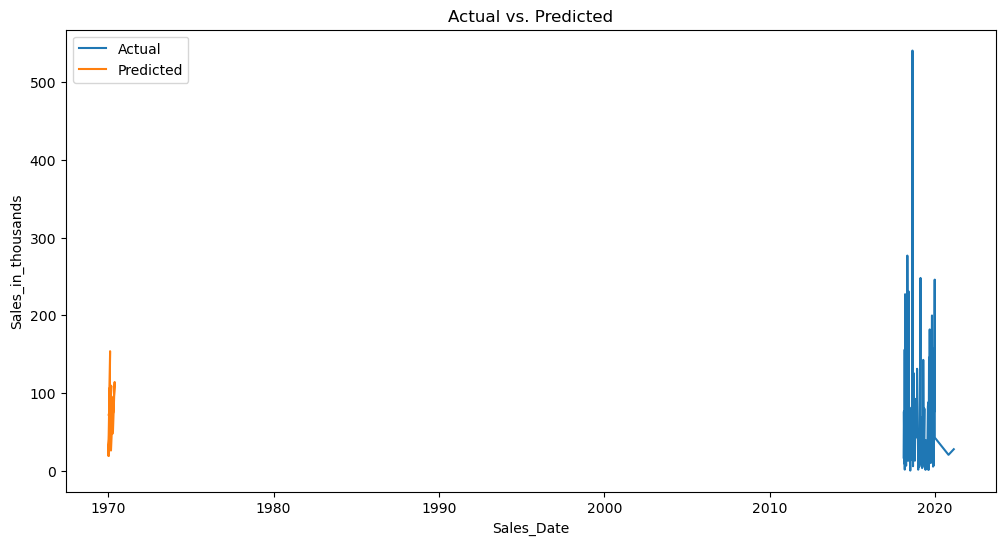

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(data['Sales_in_thousands'], label='Actual')
plt.plot(y_pred_series, label='Predicted')
plt.xlabel('Sales_Date')
plt.ylabel('Sales_in_thousands')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

In [35]:
data = data[['Sales_in_thousands', '__year_resale_value', 'Price_in_thousands']]

In [36]:
X = data[['Sales_in_thousands', '__year_resale_value']]
y = data['Price_in_thousands']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [37]:
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

In [38]:
# Create an imputer object to impute missing values with the mean
imputer = SimpleImputer(strategy='mean')

In [39]:
y_train_array = y_train.values.reshape(-1, 1)

In [40]:
y_train_imputed = imputer.fit_transform(y_train_array)

In [41]:
y_train_imputed = y_train_imputed.flatten()

In [42]:
model = XGBRegressor(random_state=123)
model.fit(X_train, y_train_imputed)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [43]:
y_pred = model.predict(X_test)

In [44]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [45]:
nan_mask = np.isnan(y_test) | np.isnan(y_pred)
y_test_cleaned = y_test[~nan_mask]
y_pred_cleaned = y_pred[~nan_mask]

In [46]:
mse = mean_squared_error(y_test_cleaned, y_pred_cleaned)
print("Mean Squared Error:", mse)

Mean Squared Error: 30.836311322962192


In [47]:
import matplotlib.pyplot as plt

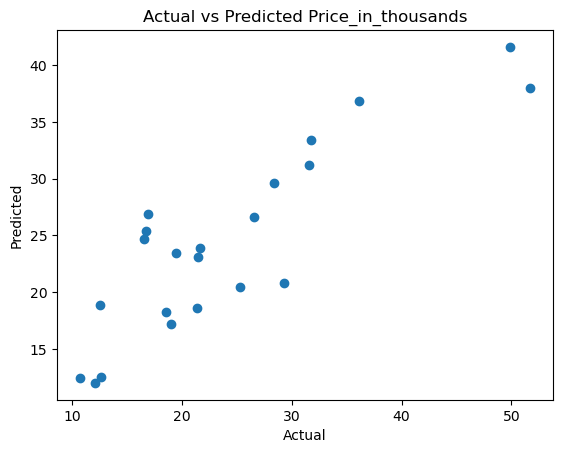

In [48]:
# Plotting Actual vs Predicted
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Price_in_thousands')
plt.show()

In [49]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [50]:
data = pd.read_csv('D:Car_sales(1).csv')

In [51]:
X = data[['Price_in_thousands']]
y = data['Sales_in_thousands']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [54]:
next_90_days = pd.date_range(start=data['Sales_Date'].iloc[-1], periods=90, freq='D')  # Assuming your data has a 'date' column
next_90_days_data = pd.DataFrame({'Sales_Date': next_90_days})
next_90_days_data['Price_in_thousands'] = 21.5

In [55]:
next_90_days_data = next_90_days_data[['Price_in_thousands']]

In [56]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [57]:
predictions = model.predict(next_90_days_data)

In [58]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [59]:
model = xgb.XGBRegressor()
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [78]:
forecast = pd.DataFrame({'Sales_in_thousands': next_90_days, 'Sales_Date': predictions})

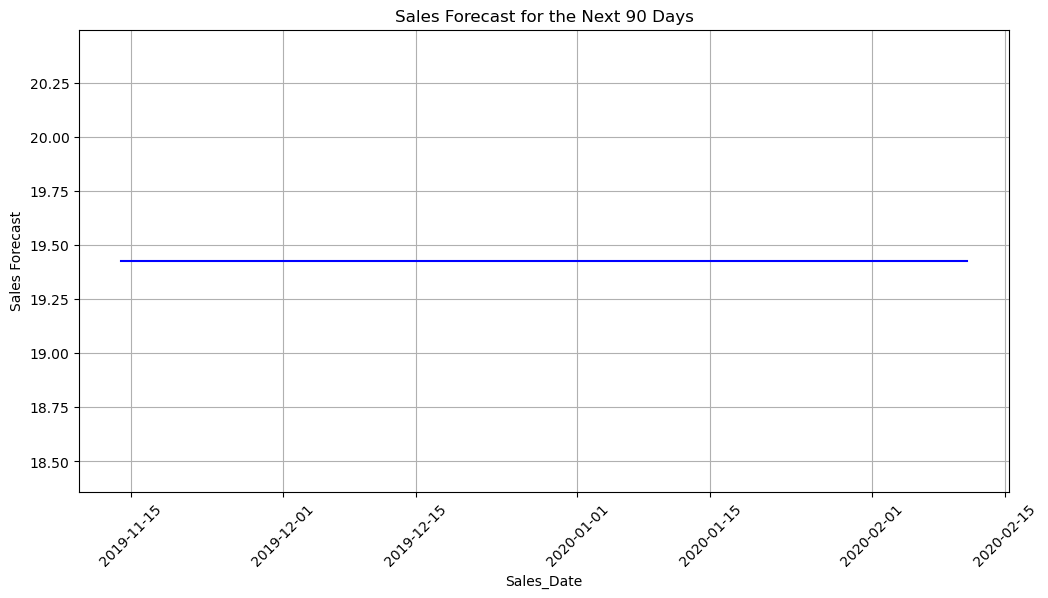

In [80]:
plt.figure(figsize=(12, 6))
plt.plot(forecast['Sales_in_thousands'], forecast['Sales_Date'], color='blue')
plt.xlabel('Sales_Date')
plt.ylabel('Sales Forecast')
plt.title('Sales Forecast for the Next 90 Days')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()